In [1]:
!pip install langdetect


[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import Libraries
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [3]:
tweets_biden = pd.read_csv("C:\\Users\\LENOVO\\OneDrive\\Desktop\\hashtag_joebiden.csv", lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv("C:\\Users\\LENOVO\\OneDrive\\Desktop\\hashtag_donaldtrump.csv", lineterminator='\n', parse_dates=True)

In [4]:
print(tweets_biden.columns)
print(tweets_trump.columns)
print(tweets_biden.dtypes)
print(tweets_trump.dtypes)

Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')
Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')
created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
source                   object
user_id                 float64
user_name                object
user_screen_name         object
user_description         object
user

In [5]:
# convert to datetime object
tweets_biden['user_join_date']=pd.to_datetime(tweets_biden['user_join_date'])
tweets_trump['user_join_date']=pd.to_datetime(tweets_trump['user_join_date'])
tweets_biden['collected_at']=pd.to_datetime(tweets_biden['collected_at'])
tweets_trump['collected_at']=pd.to_datetime(tweets_trump['collected_at'])
tweets_biden['created_at']=pd.to_datetime(tweets_biden['created_at'])
tweets_trump['created_at']=pd.to_datetime(tweets_trump['created_at'])

# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_biden['collected_at'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)



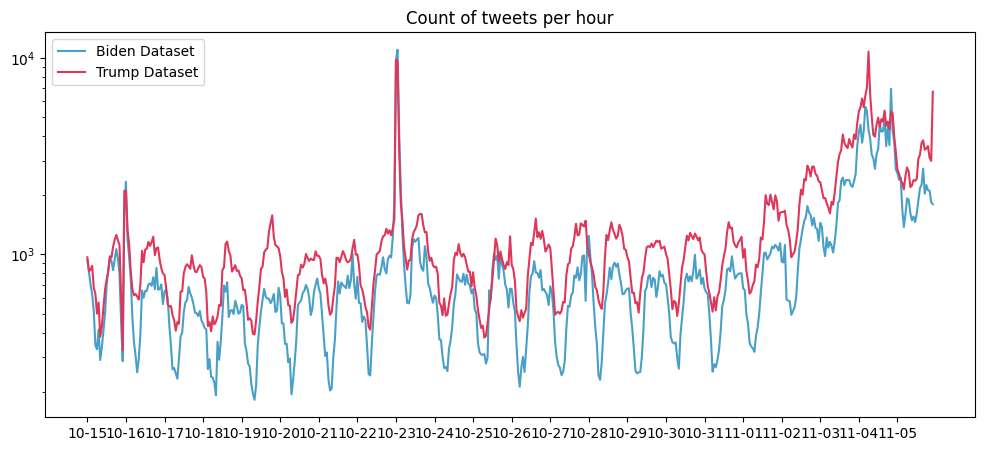

In [10]:
# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)
# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
plt.figure(figsize=(12,5))
p6=sns.lineplot(cnt_tbiden.values, color=barcolors[3], label='Biden Dataset')
p6.set_title('Count of tweets per hour')
p6=sns.lineplot(cnt_ttrump.values, color=barcolors[6], label='Trump Dataset')
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())
p6.set_yscale('log')
plt.show()

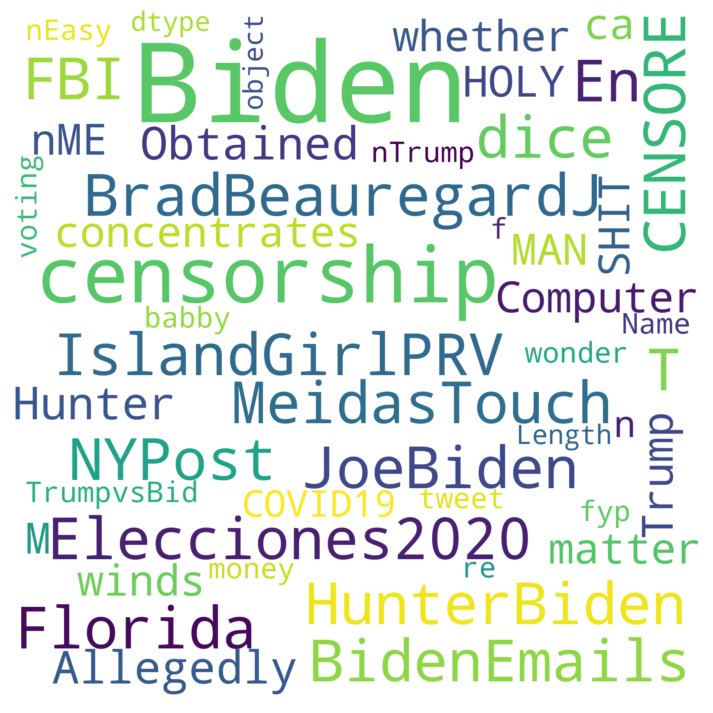

In [15]:
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

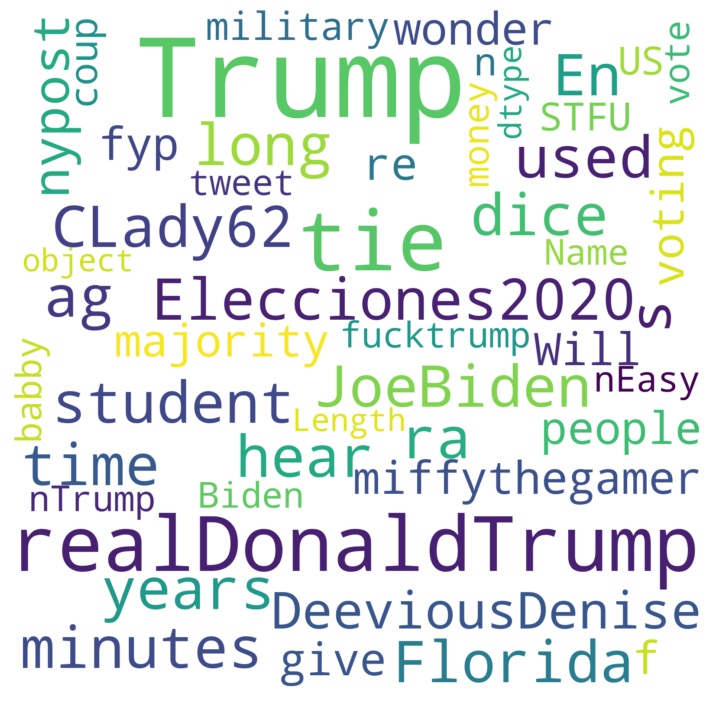

In [16]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text2.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

In [17]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

sid=SentimentIntensityAnalyzer()
# Obtain sentiment scores for both datasets
tweets_biden['VADAR']=sentiment(tweets_biden['tweet'])
tweets_trump['VADAR']=sentiment(tweets_trump['tweet'])
tweets_biden['compound']  = tweets_biden['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['compound']  = tweets_trump['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['sentiment']  = tweets_trump['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))
tweets_biden['sentiment']  = tweets_biden['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))

# Create 52 state set
states=set(tweets_biden.loc[tweets_biden['country'] == 'United States of America']['state'].dropna())
states.remove('District of Columbia')
states.remove('Northern Mariana Islands')

# Create feature to allow masking of data and then mask data for votable states
tweets_biden['voting_rights']=tweets_biden['state'].apply(lambda x: 'Yes' if x in states else 'No')
tweets_trump['voting_rights']=tweets_trump['state'].apply(lambda x: 'Yes' if x in states else 'No')
sent_t=tweets_trump.loc[tweets_trump['voting_rights'] == 'Yes']
sent_b=tweets_biden.loc[tweets_biden['voting_rights'] == 'Yes']

# Further mask data for only the last 14 days
state_b=sent_b.loc[sent_b['created_at'] > max(sent_b['created_at']) - timedelta(14)]
state_t=sent_t.loc[sent_t['created_at'] > max(sent_t['created_at']) - timedelta(14)]
state_b_mean=state_b.groupby('state')['compound'].mean().reset_index()
state_t_mean=state_t.groupby('state')['compound'].mean().reset_index()

# Further mask data for only the first 14 days
state_bp=sent_b.loc[sent_b['created_at'] < min(sent_b['created_at']) + timedelta(14)]
state_tp=sent_t.loc[sent_t['created_at'] < min(sent_t['created_at']) + timedelta(14)]
state_bp_mean=state_bp.groupby('state')['compound'].mean().reset_index()
state_tp_mean=state_tp.groupby('state')['compound'].mean().reset_index()

# Create dataframe for visualisation
states_sent=pd.DataFrame({'state':state_b_mean['state'],
                          'biden1':state_b_mean['compound'],
                          'trump1':state_t_mean['compound'],
                          'biden2':state_bp_mean['compound'],
                          'trump2':state_tp_mean['compound'],})



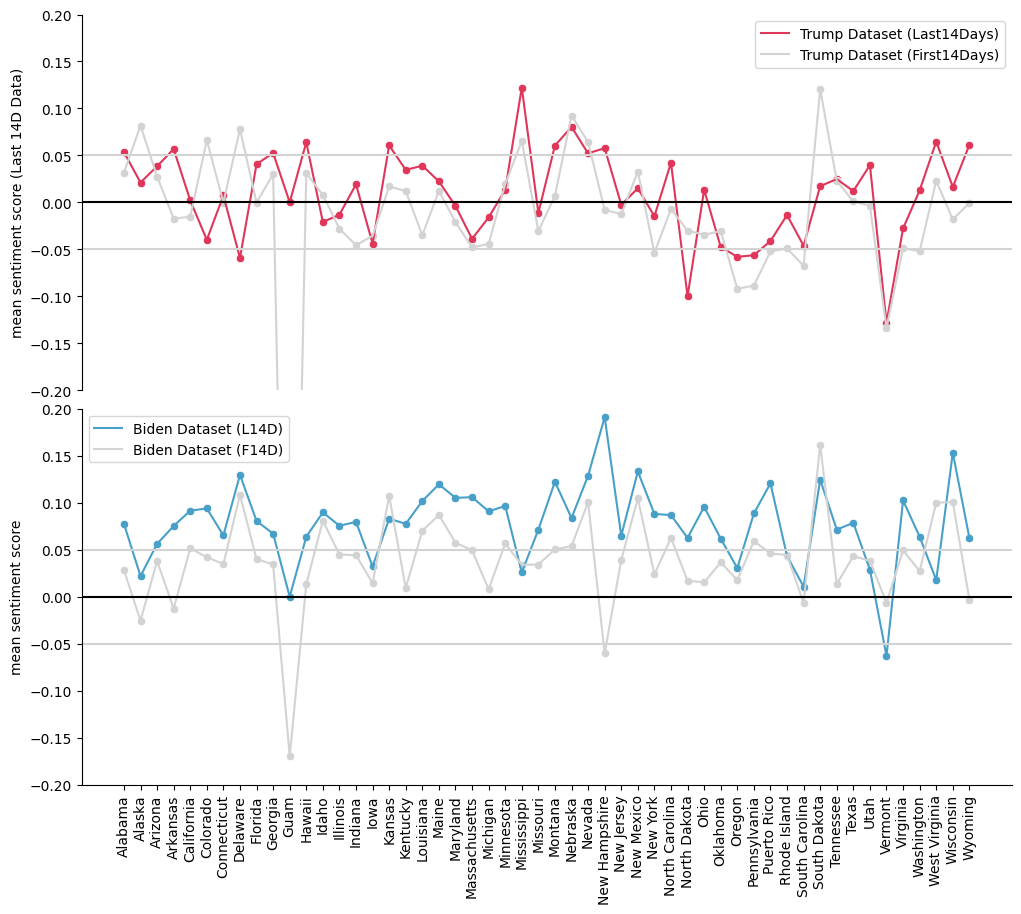

In [19]:
fig, ax=plt.subplots(2,1, figsize=(12,10), gridspec_kw={'hspace':0.05})
lineax=ax[0]
sns.lineplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax, label='Trump Dataset (Last14Days)')
sns.scatterplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax, label='Trump Dataset (First14Days)')
sns.scatterplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score (Last 14D Data)')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)
lineax=ax[1]
sns.lineplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax, label='Biden Dataset (L14D)')
sns.scatterplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax, label='Biden Dataset (F14D)')
sns.scatterplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
plt.show()


In [20]:
# Calculate counts of sentiments
stack_t=sent_t.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()
stack_b=sent_b.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()

# Setup np.arrays to allow quick calculations of the proportions of tweet sentiments
a1=np.array(stack_b.loc[stack_b.sentiment == 'pos']['tweet'].tolist())
b1=np.array(stack_b.loc[stack_b.sentiment == 'neu']['tweet'].tolist())
c1=np.array(stack_b.loc[stack_b.sentiment == 'neg']['tweet'].tolist())
d1=np.array(stack_b.groupby('created_at_r')['tweet'].sum().tolist())

a2=np.array(stack_t.loc[stack_t.sentiment == 'pos']['tweet'].tolist())
b2=np.array(stack_t.loc[stack_t.sentiment == 'neu']['tweet'].tolist())
c2=np.array(stack_t.loc[stack_t.sentiment == 'neg']['tweet'].tolist())
d2=np.array(stack_t.groupby('created_at_r')['tweet'].sum().tolist())

# Calculate sentiment proportions and feed into dataframes for visualisation
SentiDat_b=pd.DataFrame({'date':pd.to_datetime(stack_b.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_b.created_at_r.unique()),
                         'pos':a1/d1,'neu':b1/d1,'neg':c1/d1})

SentiDat_t=pd.DataFrame({'date':pd.to_datetime(stack_t.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_t.created_at_r.unique()),
                         'pos':a2/d2,'neu':b2/d2,'neg':c2/d2})


In [21]:
from seaborn import regplot

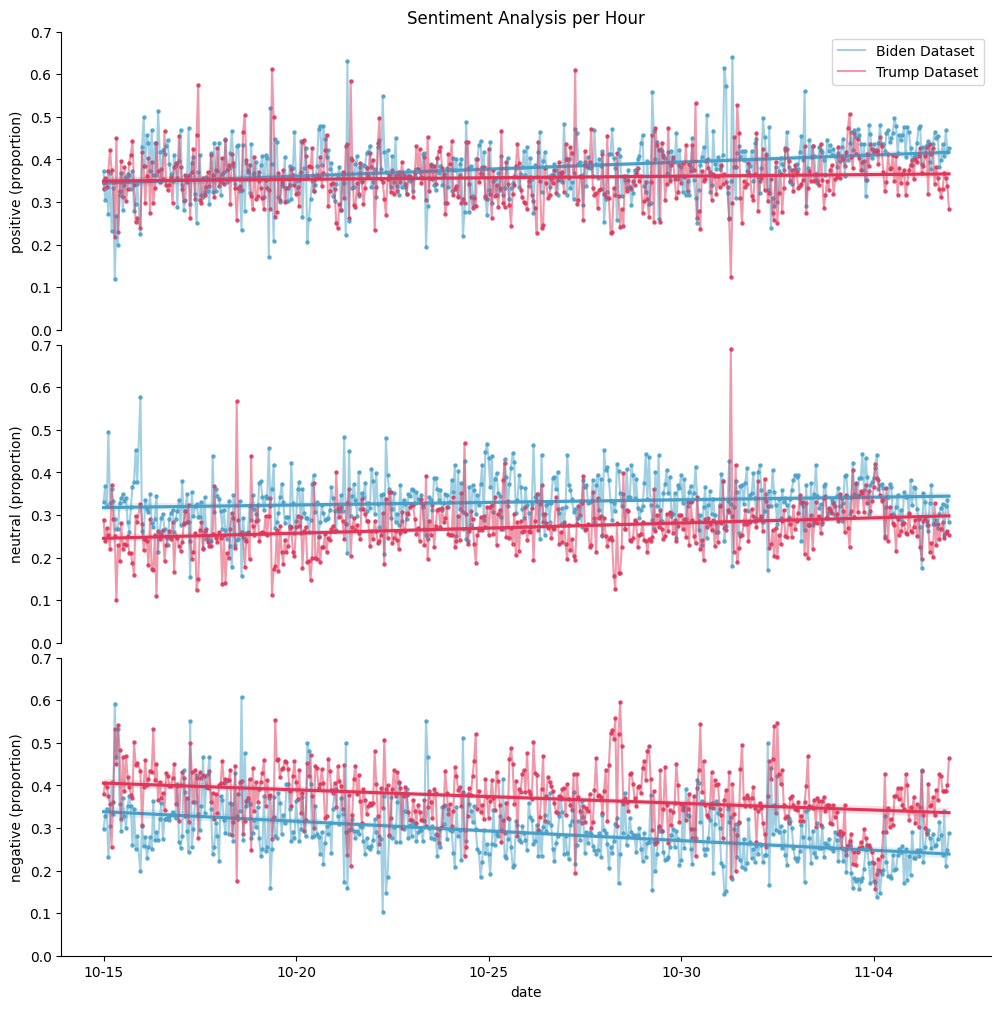

In [22]:
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 05-08"""
    return dates.num2date(x).strftime('%m-%d')

fig, ax=plt.subplots(3,1, figsize=(12,12), gridspec_kw={'hspace':0.05})
lineax=ax[0]
lineax.set_title('Sentiment Analysis per Hour')
sns.regplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], scatter_kws={'s':5}, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], alpha=0.5, label='Biden Dataset')
sns.regplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], scatter_kws={'s':5}, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], alpha=0.5, label='Trump Dataset')
lineax.xaxis.set_major_formatter(fake_dates)
lineax.set_ylim([0, 0.7])
lineax.set_xlabel('')
lineax.set_ylabel('positive (proportion)')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax1=ax[1]
sns.regplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], scatter_kws={'s':5}, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], scatter_kws={'s':5}, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], alpha=0.5)
lineax1.xaxis.set_major_formatter(fake_dates)
lineax1.set_ylim([0, 0.7])
lineax1.set_xlabel('')
lineax1.set_ylabel('neutral (proportion)')
lineax1.axes.get_xaxis().set_ticks([])
lineax1.spines['right'].set_visible(False)
lineax1.spines['top'].set_visible(False)
lineax1.spines['bottom'].set_visible(False)

lineax2=ax[2]
sns.regplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], scatter_kws={'s':5}, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], scatter_kws={'s':5}, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], alpha=0.5)
lineax2.xaxis.set_major_formatter(fake_dates)
lineax2.set_ylim([0, 0.7])
lineax2.set_ylabel('negative (proportion)')
lineax2.set_xlabel('date')
lineax2.spines['right'].set_visible(False)
lineax2.spines['top'].set_visible(False)

plt.show()


In [24]:
import plotly.express as px
import plotly.io 
from matplotlib.pyplot import figure

In [25]:
tweets_trump["Candidate"] = "TRUMP"
tweets_biden["Candidate"] = "BIDEN"
df = pd.concat([tweets_trump, tweets_biden])
df = df.sort_values(by='created_at', ignore_index=True)
state_df = df[df['country'] == 'United States of America'].dropna(subset=['state_code']).groupby(['state_code','Candidate'])['tweet'].count().reset_index()
print(state_df.head(5))
state_df = state_df.set_index(['Candidate', 'state_code']).unstack(level=0)

  state_code Candidate  tweet
0         AK     BIDEN    368
1         AK     TRUMP    262
2         AL     BIDEN    701
3         AL     TRUMP    627
4         AR     BIDEN    356


In [26]:
def getDiff(state):
    total = state[1] + state[0]
    diff = state[1] - state[0]  # trump - biden
    
    return diff/total

state_df = state_df.apply(getDiff, axis=1).reset_index().rename({0: 'diff'}, axis=1)

In [29]:
import nbformat
import plotly.graph_objs as go

In [48]:
fig = px.choropleth(state_df,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='diff',
                    color_continuous_scale=('#4040ff', '#ff4040'),
                    range_color=(-0.1,0.1),
                    color_continuous_midpoint=0,
                    )
fig.show()

In [49]:
import datetime
import time
import calendar

In [51]:
def get_day(timestamp):
    day = timestamp.day
    return day
state_time_df = df[df['country'] == 'United States of America'].dropna(subset=['state_code'])
state_time_df['day'] = state_time_df['created_at'].apply(get_day)
state_time_df = state_time_df.groupby(['state_code', 'Candidate', 'day'])['tweet'].count().reset_index()

fig = px.choropleth(state_time_df,
                    locations='state_code',
                    locationmode='USA-states',
                    animation_frame='day',
                    scope='usa',
                    color='tweet',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0, 1000),
                    width=1000,
                    height=500
                    )
fig.show()

In [53]:
df['polarity'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
def polarity_to_sentiment(x):
#     if type(x) is float:
#         for i in range(0, len(x)):
    if x > 0:
        return 1 # 1 = Positive
    if x < 0:
        return 0 # 0 = negative
    else:
        return 2 # 2 = Neutral
df['sentiments'] = df['polarity'].apply(lambda x: polarity_to_sentiment(x))


In [ ]:
# dependent Features
y = df['sentiments']

# Independent Features
x = df.drop('sentiments', axis=1)

messages = x.copy()

from nltk import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['tweet'][i])
    review = review.lower()
    review = review.split()
    review = [w for w in nltk.wordpunct_tokenize(str(review)) if w.lower() in words or not w.isalpha()]
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
voc_size = 50000
max_len = 120
embedding_features = 32
tokenizer = Tokenizer(num_words=voc_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
embedded_doc = pad_sequences(sequences, maxlen=max_len, padding= 'post', truncating = 'post')
embedded_doc[0]
x_final = np.array(embedded_doc)
y_final = np.array(y)
x_final.shape, y_final.shape


((1225482, 120), (1225482,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU

In [ ]:
model = Sequential()
model.add(Embedding(voc_size, embedding_features, input_length = max_len))
# model.add(Dropout(0.3))
model.add(GRU(100))
model.add(Dense(62, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           1600000   
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense (Dense)               (None, 62)                6262      
                                                                 
 dense_1 (Dense)             (None, 32)                2016      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,648,577
Trainable params: 1,648,577
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\lenovo\appdata\local\programs\python\python310\lib\site-packages (1.2.1)




[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size = 0.25, stratify = y, random_state=42)
model.fit(x_train, y_train, validation_data = (x_test, y_test))
y_pred = ((model.predict(x_test)>0.5).astype('int64'))

9575/9575 [==============================] - 164s 17ms/step


In [ ]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(x_test, y_test)

9575/9575 [==============================] - 159s 17ms/step - loss: 0.3449 - accuracy: 0.8859


9575/9575 [==============================] - 157s 16ms/step


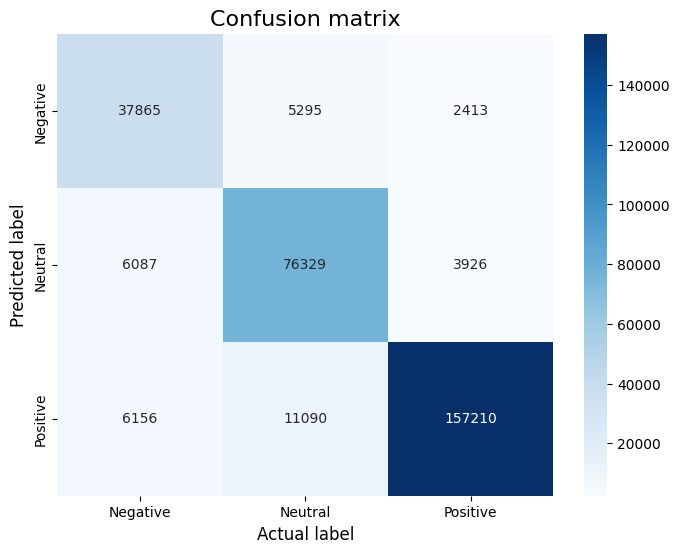

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, x_test, y_test):
    
    sentiment_classes =  ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(x_test)

    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),y_test)
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, x_test, y_test)